### Import Modules

In [0]:
import numpy as np
import h5py
from ipywidgets import interact, widgets
import random
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline



## Inputs and Hyperparameters to Neural Network

* PATH_TO_CODE_FOLDER - Path of the code folder in which Algorithm, input and output folders are present. 
* Each layer needs to be added in the below format for hidden layers variable.

[Number_of_nodes,activation,dropout_rate]
Example: [50,'LReLU',0] for hidden layer with 50 neurons and Leaky ReLu activation and with no drop out

* Input and output layers are not required to be provided in the inputs, they are automatically initialized depending on the dataset with softmax for output activation.

* batch_size - refer to size of the batch for Mini batch SGD

* epochs - Number of epochs to be used for training
* learning_rate - Rate of learning to be used while updating weights
* momentum_term - Value of gamma for "SGD with momentum". Please provide 0 for "SGD without momentum"
* epoch_for_log_display - The value of epoch for which loss and accuracy needs to be displayed during training
* weight_decay_const - Value of lambda for L2 weight regularisation. Please provide 0 for no regularisation.
* NUMBER_OF_FOLDS - Number of cross folds to be used while training the data for hyper parameter validation
* NORMALIZE_DATA - Boolean value i.e. True or False to enable of disable data normalization prior to training
* batch_normalization - Boolean value i.e. True or False to enable of batch normalization during training and testing
* c_eps - Values of epislon to be used during batch normalization

In [0]:
PATH_TO_CODE_FOLDER = "D:/OneDrive - The University of Sydney (Students)/Master of Data Science/Deep Learning/Assignment 1/For Submission/Code"
batch_size =  128
epochs = 500 #800
learning_rate=0.5
momentum_term = 0.9#0.9
epoch_for_log_display = 10
weight_decay_const = 0.0001
NUMBER_OF_FOLDS = 5
NORMALIZE_DATA =  True #True
batch_normalization = False #True

#Each layer needs to be added in the below format
hidden_layers = [
                [240,'LReLU',0.05],   #Number_of_nodes,activation,dropout_rate
                [220,'ReLU',0]
                ]

c_eps = 1e-5



### Load Data
- There are 3 files to be loaded: test_128.h5, train_128.h5, train_label.h5

In [0]:
#from google.colab import files  #Bingi 25April
#uploaded = files.upload()

if (not PATH_TO_CODE_FOLDER.endswith('/')):
    PATH_TO_CODE_FOLDER+="/"

with h5py.File(PATH_TO_CODE_FOLDER+'input/train_128.h5','r') as H:
    data = np.copy(H['data'])
    #print(data[0])   #Bingi 25April
    print("Rows, columns of data :",data.shape)

with h5py.File(PATH_TO_CODE_FOLDER+'input/train_label.h5','r') as H:
    label = np.copy(H['label'])
    #print(label[0])   #Bingi 25April
    print("Rows, columns of labels :",label.shape)

with h5py.File(PATH_TO_CODE_FOLDER+'input/test_128.h5','r') as H:
    test = np.copy(H['data'])
    #print(test[0])  #Bingi 25April
    print("Rows, columns of test data :",test.shape)

Rows, columns of data : (60000, 128)
Rows, columns of labels : (60000,)
Rows, columns of test data : (10000, 128)


### Data Normalization before training

Min Max normalisation has been applied on the given data.

$$ x_{new} = \frac {x-x_{min}}{ x_{max} - x_{min}} $$


In [0]:
# SELF IMPLEMENTED NORMALISATION

def normalise(dataset):
  # Iterate through each attribute
  for attribute in range(len(dataset[0,:])):

    # Get min and max of each attribute
    values = dataset[:, attribute]
    x_min = np.amin(values)
    x_max = np.amax(values)

    # Iterate each row
    for row in range(len(dataset[:,0])): 

      x = dataset[row, attribute] # Get value
      x_new = (x - x_min) / (x_max - x_min) # New value
      dataset[row,attribute] = x_new # Assign new value back into the dataset
      
  return dataset # Return dataset with altered values

if NORMALIZE_DATA == True:
    X_train_norm = normalise(data)
    X_test_norm = normalise(test)
else:
    X_train_norm = data
    X_test_norm = test

### Sample view of the first 8 features of the data after normalization.

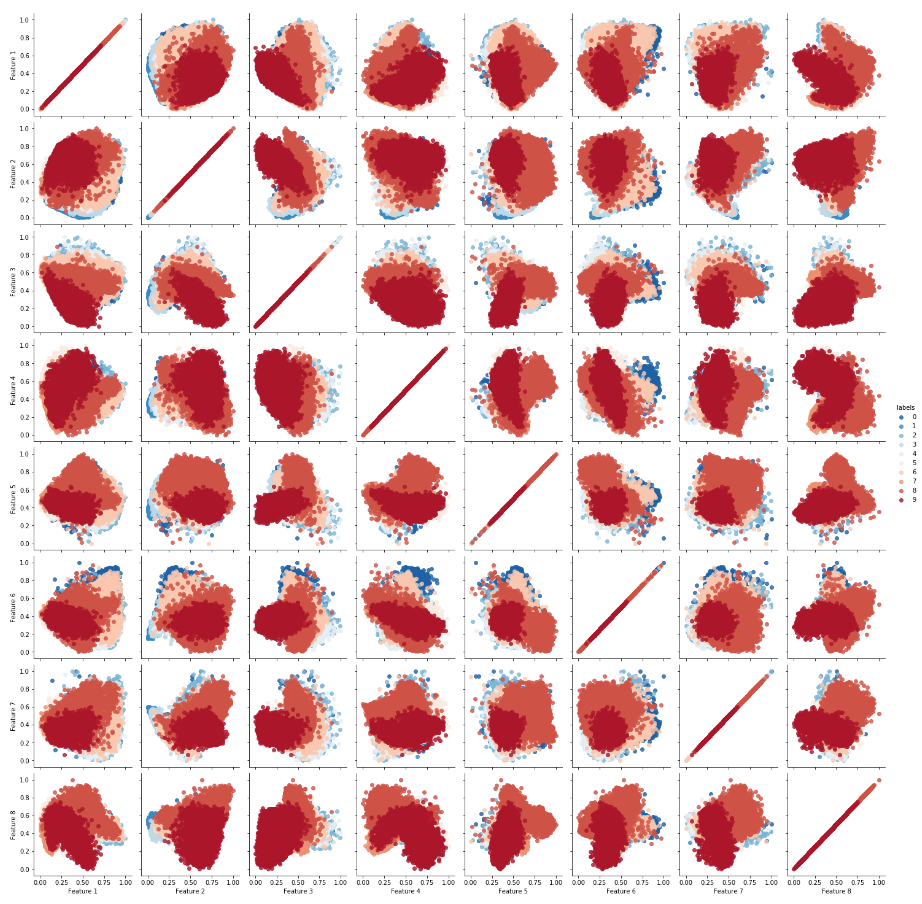

### k-fold cross validation

In [0]:
#Create batch for training and testing

max_len_to_be_used =len(X_train_norm) #To be changes only while testing during code change

import random
random_indices = random.sample(list(range(max_len_to_be_used)),max_len_to_be_used)#
#random_indices = random.sample(list(range(len(X_train_norm))),len(X_train_norm))#
validation_indices = []

for i in range(NUMBER_OF_FOLDS):
    if i == 0:
        start_counter = 0
    if i == NUMBER_OF_FOLDS-1:
        end_counter = len(X_train_norm)
    else:
        end_counter = (i+1)*round(max_len_to_be_used/NUMBER_OF_FOLDS)
    validation_indices.append(random_indices[start_counter:end_counter])
    start_counter = end_counter


### Create Mini Batches
These batches will be used for Mini Batch SGD

In [0]:
## MINI-BATCH TRAINING
def get_mini_batches(X,y,batch_size):
    '''
    Extracts randomised mini_batches from the X and y data

    X: input data
    y: input target
    batch_size: size of the mini-batch
    '''

    mini_batches = [] # Stores list of mini-batches

    # Shuffle x and y together
    flatten = zip(X,y)
    res = random.sample(list(flatten), len(X))

    # Extract the right elements from the X,y tuple
    X = np.array([i[0] for i in res])
    y = np.array([i[1] for i in res])

    for i in range (0, X.shape[0], batch_size): # start = 0 , stop = 128 , step = defined batch_size

        # splice at these indexes - of size batch_size 
        if i+batch_size <= 5000:    #Handle if the last batch is smaller than the remaining data
            X_batch = X[i: i+batch_size] 
            y_batch = y[i: i+batch_size]  
            mini_batches.append((X_batch, y_batch))
    
    return mini_batches

### Definition of Activation Functions

Linear
$$output = x$$

Tanh  
$$output = tanh(x)$$  

Sigmoid
$$output = \frac {1}{1 + e^{-x}}$$

ReLu
$$ f(x) = Maximum(x,0)$$


LReLu
$$ f(x) = x\;\;if\;\;x > 0,\;\;αx\;\;if\;\;x <= 0$$

Softmax
$$ f(x) = \frac {exp(x_i)} {\sum_jexp(x_i)} $$

We will only use softmax at the last layer to convert various values into probabilities for corresponding labels

In [0]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    def __ReLU(self,x):
        return np.maximum(0,x) # Return max value

    def __ReLU_deriv(self,x):
        dZ = np.array(x, copy = True)
        dZ[x <= 0] = 0
        dZ[x > 0] = 1
        return dZ
    
    
    def __LReLU(self,x):
        leakage = 0.01  #Leakage or alpha
        output = np.copy( x )
        output[ output < 0 ] *= leakage
        return output # Return max value

    def __LReLU_deriv(self,x):
        leakage=0.01
        return np.clip(x > 0, leakage, 1.0)

    
    def __softmax(self,x):
        exp_x = np.exp((x.T-np.amax(x,axis=1).T).T)
        return_val = (np.divide(exp_x.T,exp_x.sum(axis=1))).T
        return return_val

    
    def __softmax_deriv(self,y,y_hat):
        output = np.eye(y_hat.shape[1])[y]  #create one hot encoded vector 
        #m = y_hat.shape[1]
        m = y_hat.shape[0]
        delta = (y_hat - output)/m
        return delta
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
        elif activation == 'LReLU':
            self.f = self.__LReLU
            self.f_deriv = self.__LReLU_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv

### Hidden and Output Layers

The below functions contain logic for initilazation, forward and backward propagation of each layer.

In [0]:
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer,activation, batch_size,dropout_rate,W=None, b=None):
        """
        Typical layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        

        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv
        self.W = np.random.uniform(
                low=-1,
                high=1,
                size=(n_in, n_out)
        )

        self.b = np.zeros(n_out,)
        self.v = np.zeros(n_out,)
        
        self.dropout_rate = dropout_rate
        
        self.grad_W = np.zeros(self.W.shape)
        
        self.grad_b = np.zeros(self.b.shape)
        
        self.drop_info = np.ones(n_out,) #Store dropout information
        
        self.running_mean = np.zeros(n_out,)  #Required during backward batch normalizartion
        self.running_var = np.zeros(n_out,)    #Required during backward batch normalizartion

        self.X = np.zeros((batch_size,n_out))
        self.X_norm = np.zeros((batch_size,n_out))
        self.mu = np.zeros(n_out,)
        self.var = np.zeros(n_out,)
        
        self.gamma = np.ones(n_out,)
        self.beta = np.ones(n_out,)

        self.X_shape = (batch_size,n_out) #Dummy assignment

        
    def forward(self, input,input_withoutdrop,do_dropout, momentum,c_eps,train,batch_normalization=False):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b 
        if do_dropout == True:  #Perform dropout
            self.drop_info = np.random.binomial([np.ones(lin_output.shape[1])],1-self.dropout_rate)[0] * (1.0/(1-self.dropout_rate))
            lin_output=lin_output*self.drop_info           
        opbefore_batch = lin_output  #Storing to use this during backpropagation
        
        if batch_normalization:  #perform batch normalization during forward if enabled
            lin_output = self.batchnorm_forward(lin_output, momentum,c_eps, train)  
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        
        if train: #update output of previous as input of this layer only during training
            self.input=input_withoutdrop
            
        return self.output,opbefore_batch
    
    #Function for performing forward propgation if batch normalization is enabled
    def batchnorm_forward(self, input, momentum=.9,c_eps=1e-5, train=True):
        #The steps are slightly different for training and testing
        if train:            
            n_X = input.shape[0]
            self.X_shape = input.shape        
            self.X  = input.ravel().reshape(n_X,-1)
            self.mu = np.mean(self.X ,axis=0)
            self.var = np.var(self.X , axis=0)
            X_norm = (self.X - self.mu)/np.sqrt(self.var + 1e-8)
            X_out = self.gamma * X_norm + self.beta
            
            #update running mean, variance to be used during prediction phase
            self.running_mean = momentum * self.running_mean + (1. - momentum) *self.mu       
            self.running_var = momentum * self.running_var + (1. - momentum) * self.var 
            self.X_norm = X_norm           
        else:
            n_X = input.shape[0]
            self.X_shape = input.shape        
            self.X  = input.ravel().reshape(n_X,-1)
            X_norm = (self.X - self.running_mean) / np.sqrt(self.running_var + c_eps)
            print(self.gamma.shape)
            X_out = self.gamma * X_norm + self.beta
        return X_out.reshape(self.X_shape)
    



    
    def backward(self, delta, c_eps,output_layer=False,\
                 weight_decay_const=0):
        m = self.input.shape[0]
        #delta= self.drop_info *delta #dropout during back propagation
  
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))/m
        self.grad_b = np.sum(delta, axis=0)
        self.grad_W+=weight_decay_const*self.W/m  #Adding L2 regularisation

        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
            
        return delta

    #Function for performing backward propgation if batch normalization is enabled
    def batchnorm_backward(self, delta,c_eps):  
        delta = np.sum(delta, axis=0)
        m = self.input.shape[0]
        dout = delta.ravel().reshape(delta.shape[0],-1)
        X_mu = self.X - self.mu
        var_inv = 1./np.sqrt(self.var + 1e-8)
        
        dbeta = np.sum(dout,axis=0)
        dgamma = dout * self.X_norm

        dX_norm = dout * self.gamma
        dvar = np.sum(dX_norm * X_mu,axis=0) * -0.5 * (self.var +c_eps)**(-3/2)
        dmu = np.sum(dX_norm * -var_inv ,axis=0) + dvar * 1/m * np.sum(-2.* X_mu, axis=0)
        dX = (dX_norm * var_inv) + (dmu / m) + (dvar * 2/m * X_mu)
        
        dX = dX.reshape(self.X_shape)
        self.gamma = dgamma
        self.beta = dbeta

        return dX
        

### Cross Entropy Loss
$$ CE = -\sum_it_ilog({s_i})  $$

We will use cross Entropy loss to calculate loss, delta for performing back propagation as we are using softmax in the last layer.


## Neural Network

The class initialized out Neural Network with a fully configurable number of layers and neurons. It adapts its weights using the backpropagation algorithm in an online manner taking into consider a number of techniques like L2 regularization, dropout, momentum etc.

In [0]:
class MLP:
    """
    """      
    def __init__(self, layers, activation,batch_size,dropout_rates):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        self.batch_size = batch_size
        self.activation=activation
        #Create layers with input, output size, activation function, dropout rate
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],batch_size,dropout_rates[i]))
    
    def forward(self,input,do_dropout, momentum,c_eps, train,batch_normalization): 

        for id,layer in enumerate(self.layers):            
            if id == len(self.layers)-1:  #To ensure dropout is not performed on last layer
                if id ==0:
                    output,output_withoutdrop=layer.forward(input,input,False, momentum,c_eps, train,batch_normalization)  #Bingi 25april
                else:
                    output,output_withoutdrop=layer.forward(input,input_withoutdrop,False, momentum,c_eps, train,batch_normalization)  #Bingi 25april
            else:
                if id ==0:
                    output,output_withoutdrop=layer.forward(input,input,do_dropout, momentum,c_eps, train,batch_normalization) #Bingi 25april               
                else:
                    output,output_withoutdrop=layer.forward(input,input_withoutdrop,do_dropout, momentum,c_eps, train,batch_normalization) #Bingi 25april
            input=output
            input_withoutdrop=output_withoutdrop
        return output
    
    
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        error = y-y_hat      
        loss=np.average(error**2) #Averaging all errors to calculate MSE
        delta=-error*activation_deriv(y_hat)
        return loss,delta # return loss and delta
    
    def cross_entropy(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        output = np.eye(y_hat.shape[1])[y]
        m = y_hat.shape[1]
        loss = -np.sum(output*np.log(y_hat),axis=1)
        delta=activation_deriv(y,y_hat)
        return np.squeeze(loss),delta

        
    def backward(self,delta,weight_decay_const,c_eps,batch_normalization):
        delta=self.layers[-1].backward(delta,c_eps=c_eps,output_layer=True,\
                        weight_decay_const=weight_decay_const)
        if "Error" in delta:
            return 1,delta
        #Perform backward propogation for all layers
        for id,layer in enumerate(reversed(self.layers[:-1])):
            if batch_normalization:
                delta = layer.batchnorm_backward(delta, c_eps)
            delta=layer.backward(delta,c_eps=c_eps,output_layer=False,\
                                 weight_decay_const=weight_decay_const)
            if "Error" in delta:
                return 1,delta
        return 0,"Success"


            
    def update(self,lr, gamma=0.9):
        for id,layer in enumerate(self.layers):
            layer.v = gamma * layer.v + lr * layer.grad_W  #apply momentun based SGD
            layer.W -= layer.v
            layer.b -= lr * layer.grad_b
            
            

    def fit(self,X,y,c_eps,batch_normalization,learning_rate=0.1, epochs=100,weight_decay_const=0,\
            loss_print_step=20,momentum_term=0.9): 
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """

        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        acc_to_return = np.zeros(epochs)
        
        #Validations before starting training
        if len(X) == 0 or len(y)==0:
            return 1,"Training exiting as input data is empty"
        
        for k in range(epochs):
            mini_batches = get_mini_batches(X, y, self.batch_size)
            loss=np.zeros(len(mini_batches))
            acc_tr=np.zeros(len(mini_batches))
            for it in range(len(mini_batches)):              
                x_batch,y_batch = mini_batches[it]              
                #Perform forward propagation on the entire batch at one
                y_hat = self.forward(x_batch,True, momentum_term,c_eps, True\
                                     ,batch_normalization) 
                loss_batch,delta_batch=self.cross_entropy(y_batch,y_hat)
                update_delta = delta_batch
                
                #Perform backward propagation once for the entire batch
                return_code, message = self.backward(update_delta,weight_decay_const,c_eps,batch_normalization)
                if return_code == 1:
                    return 1,"Training exiting as error during back propagation"
                self.update(learning_rate,momentum_term)

                loss[it]= np.mean(loss_batch)
                batch_output = np.argmax(y_hat, axis=1)
                acc_tr[it] = (sum(y_batch == batch_output)/len(y_batch))*100
            to_return[k] = np.mean(loss)
            acc_to_return[k]=np.mean(acc_tr)
            if k % loss_print_step == (loss_print_step-1):
                 print('Epoch: %d, loss: %.3f, accuracy: %.2f' %(k + 1, to_return[k].item(),acc_to_return[k]))
        return 0,to_return,acc_to_return

    def predict(self, x):
        x = np.array(x)
        output = np.argmax(self.forward(x,False,1,1, False,batch_normalization), axis=1) 
        return output

## Input Initialization

In [0]:
import warnings
import datetime
warnings.filterwarnings('ignore')


n_input = np.size(data,1) #First layer size
n_output = len(np.unique(label)) #Last layer size = Unique labels to be preddicted

MLP_inputs = [n_input]
dropout_rates = [0]
activations = [None]
ValidationPass = True  #Flag to validate before training

for each_layer in hidden_layers:
    if each_layer[1] in ['LReLU','ReLU','tanh','logistic']:
        activations.append(each_layer[1])
    else:
        print(each_layer[1],"is not a valid activation function. Please choose from LReLU,ReLU,tanh,logistic.")
        ValidationPass = False
    try:
        MLP_inputs.append(int(each_layer[0]))
    except:
        print(each_layer[0],"does not seem like size of a hidden layer.")
        ValidationPass = False
    #MLP_inputs.append(each_layer[0])
    if each_layer[2] < 1:
        dropout_rates.append(each_layer[2])
    else:
        print(each_layer[2],"should be less than 1.")
        ValidationPass = False
        
try:
    x = int(batch_size)
except:
    print(batch_size,"does not seem like a integer.")
    ValidationPass = False
    
try:
    x = int(epochs)
except:
    print(epochs,"does not seem like a integer.")
    ValidationPass = False
        
if learning_rate >= 1:
    print(learning_rate,"should be less than 1.")
    ValidationPass = False
    
if momentum_term >= 1:
    print(momentum_term+"(gamma) should be less than 1.")
    ValidationPass = False

if weight_decay_const >= 1:
    print(weight_decay_const+"(lamda) should be less than 1.")
    ValidationPass = False
            
activations.append("softmax")
MLP_inputs.append(n_output)

## Training and prediction
Once the hyperparameters are set. Please execute this cell for training the neural network on entire training data and generate labels for test data.

Training started @ 30-04-2020 20:20:20
Epoch: 10, loss: 1.587, accuracy: 50.34
Epoch: 20, loss: 1.183, accuracy: 64.14
Epoch: 30, loss: 0.962, accuracy: 71.21
Epoch: 40, loss: 0.832, accuracy: 74.38
Epoch: 50, loss: 0.777, accuracy: 74.98
Epoch: 60, loss: 0.725, accuracy: 77.00
Epoch: 70, loss: 0.710, accuracy: 76.92
Epoch: 80, loss: 0.650, accuracy: 78.00
Epoch: 90, loss: 0.643, accuracy: 78.59
Epoch: 100, loss: 0.623, accuracy: 79.37
Epoch: 110, loss: 0.602, accuracy: 79.19
Epoch: 120, loss: 0.572, accuracy: 79.93
Epoch: 130, loss: 0.573, accuracy: 80.39
Epoch: 140, loss: 0.578, accuracy: 79.73
Epoch: 150, loss: 0.556, accuracy: 81.15
Epoch: 160, loss: 0.562, accuracy: 80.75
Epoch: 170, loss: 0.529, accuracy: 81.39
Epoch: 180, loss: 0.529, accuracy: 82.41
Epoch: 190, loss: 0.524, accuracy: 81.91
Epoch: 200, loss: 0.530, accuracy: 82.01
Epoch: 210, loss: 0.492, accuracy: 82.11
Epoch: 220, loss: 0.528, accuracy: 82.35
Epoch: 230, loss: 0.501, accuracy: 82.41
Epoch: 240, loss: 0.500, ac

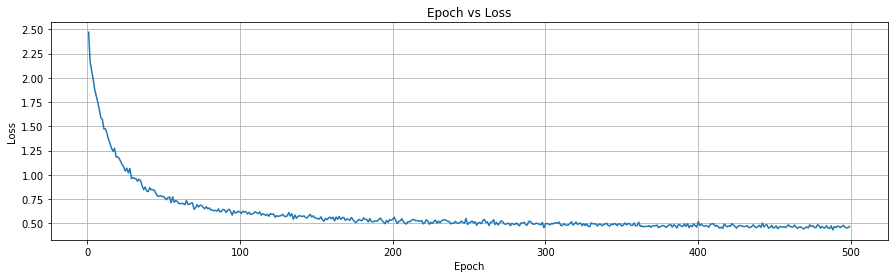

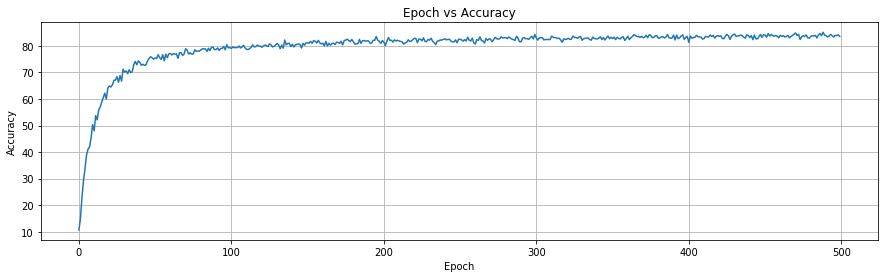

Prediction completed on test data.
Labels have been saved in D:/OneDrive - The University of Sydney (Students)/Master of Data Science/Deep Learning/Assignment 1/For Submission/Code/output/Predicted_labels_30-04-2020_20-26-59.h5


In [0]:
if ValidationPass == True:
    starttime = datetime.datetime.now()
    print("Training started @ "+starttime.strftime("%d-%m-%Y %H:%M:%S"))
    nn = MLP(MLP_inputs, activations,batch_size,dropout_rates)
    Exit_Status,Loss,Acc_Train = nn.fit(X_train_norm, label, learning_rate=learning_rate, \
                                  epochs=epochs,weight_decay_const=weight_decay_const,loss_print_step=epoch_for_log_display\
                                ,c_eps=c_eps,batch_normalization=batch_normalization,\
                                 momentum_term=momentum_term)

    if Exit_Status == 1:
        print(Loss)
    else:
        endtime = datetime.datetime.now()
        print("Training ended @ "+endtime.strftime("%d-%m-%Y %H:%M:%S"))
        print("Time taken for training :",endtime-starttime)
        plt.figure(figsize=(15,4))
        plt.plot(Loss)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Epoch vs Loss")
        plt.grid()
        plt.show()

        plt.figure(figsize=(15,4))
        plt.plot(Acc_Train)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Epoch vs Accuracy")
        plt.grid()
        plt.show()
        #Perform prediction of testdata
        output_test = nn.predict(X_test_norm)
        #Save test data in a h5 file
        #Adding data time in filename so that the previous files are not lost
        filename = PATH_TO_CODE_FOLDER +"output/Predicted_labels_"+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+".h5"
        hf = h5py.File(filename, 'w')
        hf.create_dataset('label',data=np.array(output_test))
        hf.close()
        print("Prediction completed on test data.\nLabels have been saved in "+filename)

### Evaluate hyper parameters via cross validation

#### Only run this cell if you want to evaluate different hyper parameters.

Training 1 started @ 30-04-2020 21:44:51
Epoch: 10, loss: 1.494, accuracy: 48.96
Epoch: 20, loss: 1.110, accuracy: 61.64
Epoch: 30, loss: 0.967, accuracy: 66.13
Epoch: 40, loss: 0.842, accuracy: 69.81
Epoch: 50, loss: 0.771, accuracy: 72.84
Epoch: 60, loss: 0.708, accuracy: 75.50
Epoch: 70, loss: 0.694, accuracy: 75.38
Epoch: 80, loss: 0.669, accuracy: 77.14
Epoch: 90, loss: 0.640, accuracy: 77.00
Epoch: 100, loss: 0.630, accuracy: 77.24
Epoch: 110, loss: 0.598, accuracy: 78.71
Epoch: 120, loss: 0.589, accuracy: 78.93
Epoch: 130, loss: 0.578, accuracy: 80.05
Epoch: 140, loss: 0.549, accuracy: 80.67
Epoch: 150, loss: 0.539, accuracy: 80.65
Epoch: 160, loss: 0.514, accuracy: 82.41
Epoch: 170, loss: 0.536, accuracy: 81.11
Epoch: 180, loss: 0.520, accuracy: 81.17
Epoch: 190, loss: 0.516, accuracy: 81.37
Epoch: 200, loss: 0.496, accuracy: 82.69
Epoch: 210, loss: 0.492, accuracy: 82.19
Epoch: 220, loss: 0.482, accuracy: 82.47
Epoch: 230, loss: 0.492, accuracy: 82.13
Epoch: 240, loss: 0.484, 

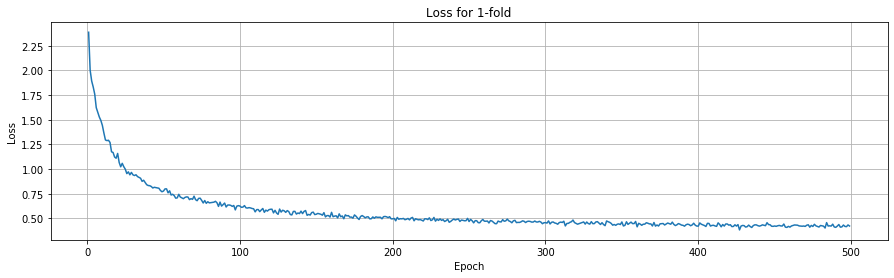

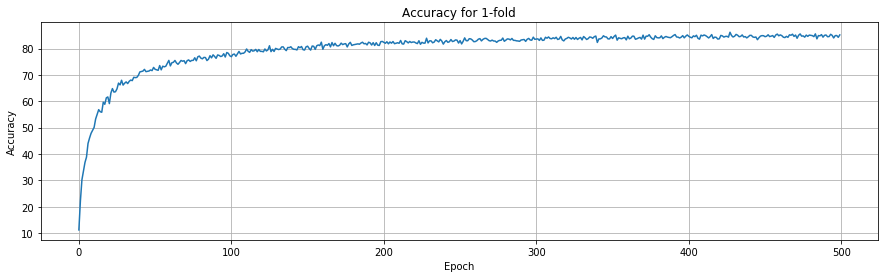

Training 2 started @ 30-04-2020 21:50:53
Epoch: 10, loss: 1.678, accuracy: 42.71
Epoch: 20, loss: 1.240, accuracy: 57.93
Epoch: 30, loss: 1.031, accuracy: 65.44
Epoch: 40, loss: 0.894, accuracy: 69.03
Epoch: 50, loss: 0.818, accuracy: 71.25
Epoch: 60, loss: 0.735, accuracy: 75.12
Epoch: 70, loss: 0.714, accuracy: 75.22
Epoch: 80, loss: 0.660, accuracy: 76.70
Epoch: 90, loss: 0.654, accuracy: 77.54
Epoch: 100, loss: 0.602, accuracy: 78.63
Epoch: 110, loss: 0.609, accuracy: 78.23
Epoch: 120, loss: 0.577, accuracy: 79.49
Epoch: 130, loss: 0.563, accuracy: 80.25
Epoch: 140, loss: 0.556, accuracy: 80.57
Epoch: 150, loss: 0.550, accuracy: 80.29
Epoch: 160, loss: 0.571, accuracy: 79.77
Epoch: 170, loss: 0.541, accuracy: 80.67
Epoch: 180, loss: 0.549, accuracy: 81.55
Epoch: 190, loss: 0.546, accuracy: 80.57
Epoch: 200, loss: 0.520, accuracy: 81.93
Epoch: 210, loss: 0.530, accuracy: 81.59
Epoch: 220, loss: 0.519, accuracy: 82.09
Epoch: 230, loss: 0.501, accuracy: 81.95
Epoch: 240, loss: 0.511, 

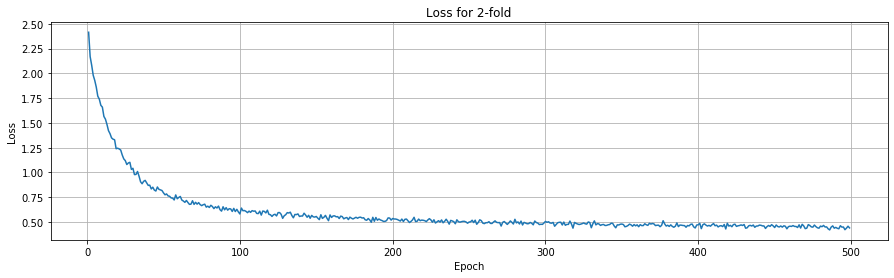

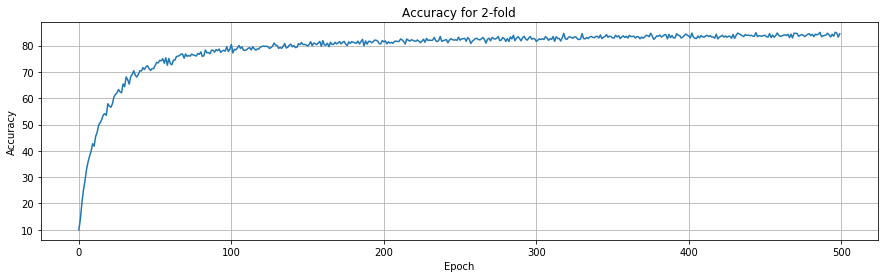

Training 3 started @ 30-04-2020 21:57:23
Epoch: 10, loss: 1.820, accuracy: 42.15
Epoch: 20, loss: 1.379, accuracy: 56.97
Epoch: 30, loss: 1.140, accuracy: 63.82
Epoch: 40, loss: 0.981, accuracy: 67.87
Epoch: 50, loss: 0.856, accuracy: 71.29
Epoch: 60, loss: 0.870, accuracy: 69.49
Epoch: 70, loss: 0.768, accuracy: 73.74
Epoch: 80, loss: 0.782, accuracy: 73.96
Epoch: 90, loss: 0.741, accuracy: 74.46
Epoch: 100, loss: 0.689, accuracy: 77.02
Epoch: 110, loss: 0.657, accuracy: 76.98
Epoch: 120, loss: 0.621, accuracy: 78.02
Epoch: 130, loss: 0.629, accuracy: 78.10
Epoch: 140, loss: 0.582, accuracy: 79.89
Epoch: 150, loss: 0.588, accuracy: 79.43
Epoch: 160, loss: 0.582, accuracy: 80.15
Epoch: 170, loss: 0.570, accuracy: 79.43
Epoch: 180, loss: 0.583, accuracy: 80.19
Epoch: 190, loss: 0.556, accuracy: 80.49
Epoch: 200, loss: 0.561, accuracy: 80.39
Epoch: 210, loss: 0.564, accuracy: 80.03
Epoch: 220, loss: 0.532, accuracy: 81.29
Epoch: 230, loss: 0.565, accuracy: 80.09
Epoch: 240, loss: 0.539, 

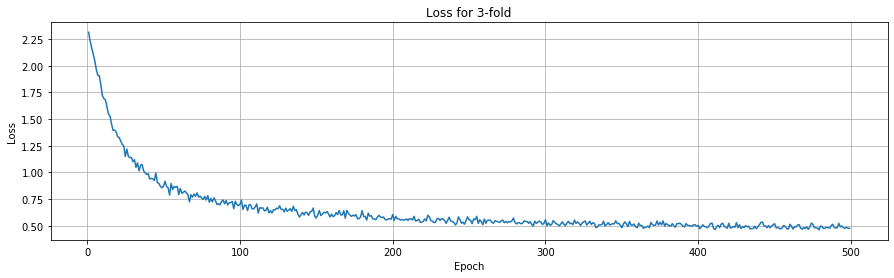

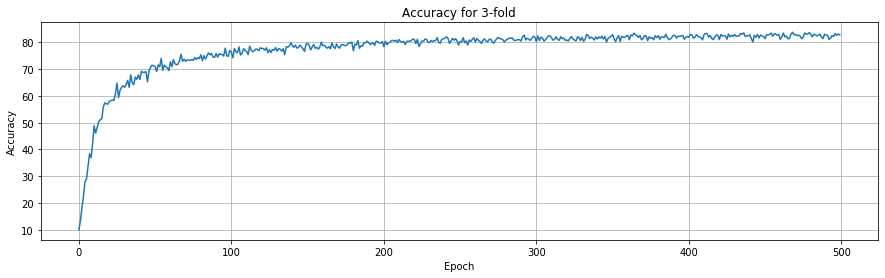

Training 4 started @ 30-04-2020 22:03:58
Epoch: 10, loss: 1.465, accuracy: 50.14
Epoch: 20, loss: 1.132, accuracy: 61.22
Epoch: 30, loss: 0.940, accuracy: 67.61
Epoch: 40, loss: 0.902, accuracy: 68.65
Epoch: 50, loss: 0.780, accuracy: 72.18
Epoch: 60, loss: 0.723, accuracy: 74.94
Epoch: 70, loss: 0.702, accuracy: 75.30
Epoch: 80, loss: 0.672, accuracy: 76.60
Epoch: 90, loss: 0.663, accuracy: 75.92
Epoch: 100, loss: 0.618, accuracy: 78.19
Epoch: 110, loss: 0.659, accuracy: 75.96
Epoch: 120, loss: 0.611, accuracy: 78.04
Epoch: 130, loss: 0.612, accuracy: 78.69
Epoch: 140, loss: 0.600, accuracy: 78.41
Epoch: 150, loss: 0.594, accuracy: 78.53
Epoch: 160, loss: 0.553, accuracy: 80.63
Epoch: 170, loss: 0.566, accuracy: 80.51
Epoch: 180, loss: 0.549, accuracy: 80.11
Epoch: 190, loss: 0.509, accuracy: 81.43
Epoch: 200, loss: 0.518, accuracy: 81.93
Epoch: 210, loss: 0.542, accuracy: 80.69
Epoch: 220, loss: 0.550, accuracy: 81.03
Epoch: 230, loss: 0.513, accuracy: 81.73
Epoch: 240, loss: 0.521, 

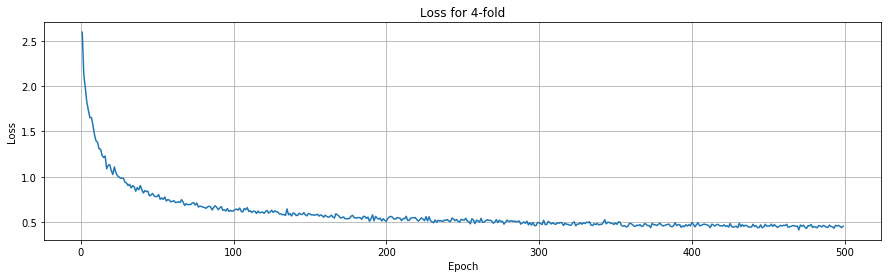

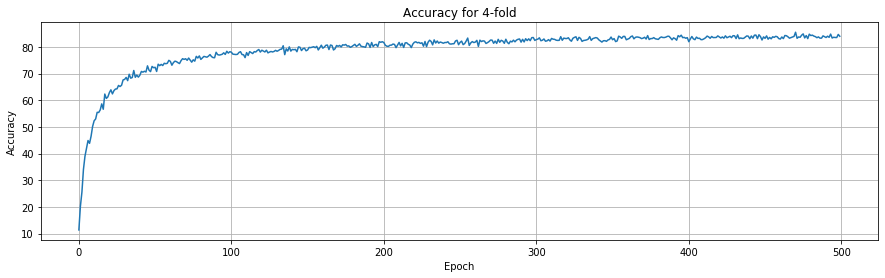

Training 5 started @ 30-04-2020 22:10:33
Epoch: 10, loss: 1.441, accuracy: 52.92
Epoch: 20, loss: 1.086, accuracy: 65.42
Epoch: 30, loss: 0.911, accuracy: 71.47
Epoch: 40, loss: 0.799, accuracy: 73.62
Epoch: 50, loss: 0.745, accuracy: 75.44
Epoch: 60, loss: 0.720, accuracy: 76.44
Epoch: 70, loss: 0.666, accuracy: 78.25
Epoch: 80, loss: 0.654, accuracy: 78.43
Epoch: 90, loss: 0.612, accuracy: 79.17
Epoch: 100, loss: 0.610, accuracy: 79.59
Epoch: 110, loss: 0.593, accuracy: 79.67
Epoch: 120, loss: 0.587, accuracy: 79.61
Epoch: 130, loss: 0.546, accuracy: 81.07
Epoch: 140, loss: 0.550, accuracy: 81.39
Epoch: 150, loss: 0.562, accuracy: 80.61
Epoch: 160, loss: 0.526, accuracy: 81.97
Epoch: 170, loss: 0.516, accuracy: 82.47
Epoch: 180, loss: 0.531, accuracy: 81.79
Epoch: 190, loss: 0.501, accuracy: 82.49
Epoch: 200, loss: 0.507, accuracy: 82.11
Epoch: 210, loss: 0.508, accuracy: 82.51
Epoch: 220, loss: 0.505, accuracy: 82.59
Epoch: 230, loss: 0.503, accuracy: 83.03
Epoch: 240, loss: 0.487, 

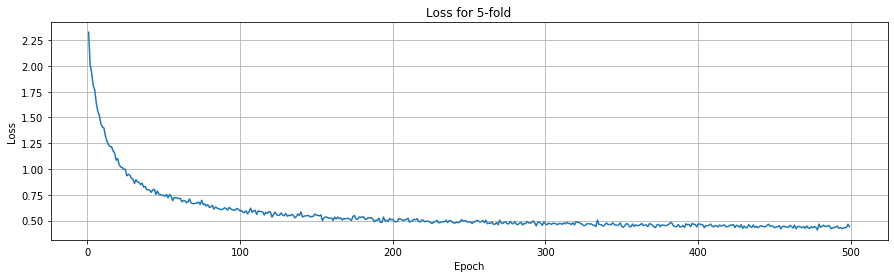

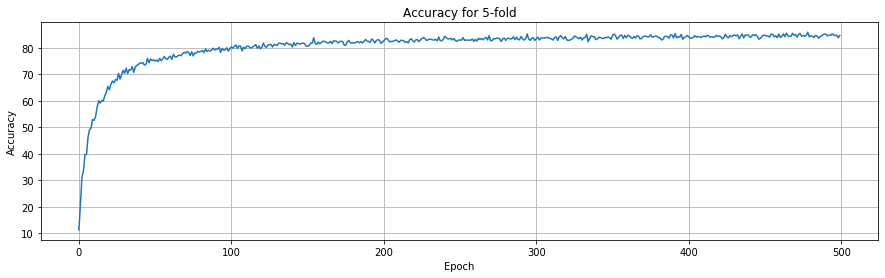

Final Accuracy: 84.17833333333334


In [0]:
import warnings
import datetime
warnings.filterwarnings('ignore')


if ValidationPass == True:
    
    accuracies = []
    #Loop for each fold
    for i in range(len(validation_indices)):  
        indexes_for_validation_data = validation_indices[i]
        indexes_for_traindata = [y for y in range(max_len_to_be_used) if not y in indexes_for_validation_data] #Create indices for training data

        #Training Data and Labels
        data_train=X_train_norm[indexes_for_traindata,]
        labels_train =label[indexes_for_traindata]

        #Validation Data and Labels
        data_validation=X_train_norm[indexes_for_validation_data,]
        labels_validation =  label[indexes_for_validation_data]

        starttime = datetime.datetime.now()
        print("Training "+str(i+1)+" started @ "+starttime.strftime("%d-%m-%Y %H:%M:%S"))
        #Initialize MLP
        nn = MLP(MLP_inputs, activations,batch_size,dropout_rates)
        #Start Training
        Exit_Status,Loss,Acc_Train = nn.fit(data_train, labels_train, learning_rate=learning_rate, \
                              epochs=epochs,weight_decay_const=weight_decay_const,loss_print_step=epoch_for_log_display\
                            ,c_eps=c_eps,batch_normalization=batch_normalization,\
                             momentum_term=momentum_term)
    
        if Exit_Status == 1:
            print(Loss)
            break
        endtime = datetime.datetime.now()
        print("Training "+str(i+1)+" ended @ "+endtime.strftime("%d-%m-%Y %H:%M:%S"))
        print("Time taken for training :",endtime-starttime)
        
        #Perform prediction on validation data
        output = nn.predict(data_validation)
        accuracy = sum(labels_validation == output)/len(labels_validation)*100
        accuracies.append(accuracy)
        print("Accuracy on validation data:",accuracy)
        plt.figure(figsize=(15,4))
        plt.plot(Loss)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss for "+str(i+1)+"-fold")
        plt.grid()
        plt.show()

        plt.figure(figsize=(15,4))
        plt.plot(Acc_Train)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy for "+str(i+1)+"-fold")
        plt.grid()
        plt.show()
        
    if len(accuracies) > 0:
        print("Final Accuracy:",sum(accuracies)/len(accuracies))
        